In [1]:
!pip install --upgrade tensorflow-federated
!pip install -q --upgrade nest_asyncio
!pip install xlsxwriter
!pip install jax>=0.4.9
!pip install cachetools>=4.2.1

In [2]:
import nest_asyncio
nest_asyncio.apply()

import random
import time
import keras
import random
import xlsxwriter
import collections
import numpy as np
import pandas as pd
import tensorflow as tf
from typing import Optional, List, Tuple
from sklearn import metrics
import matplotlib.pyplot as plt
import tensorflow_federated as tff
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
import functools

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
"""# Dataset"""
ratings_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ratings_1m.csv')

print('Total number of users:', len(set(ratings_df.userId)))
print('Total number of movies:', len(set(ratings_df.movieId)))

movies = ratings_df.movieId.tolist()
movies_allowed = np.array(list(set(movies)))
num_movies = len(movies_allowed)

users = ratings_df.userId.tolist()
users_allowed = np.array(list(set(users)))
num_users = len(users_allowed)

Total number of users: 6040
Total number of movies: 3706


# New Section

## Federated dataset

In [5]:
from IPython.core.display import Javascript
def create_tf_datasets(ratings_df: pd.DataFrame,
                       batch_size: int = 1,
                      #  num_users: int = 10,why is this not given as input?
                       clients: int=1) -> List[tf.data.Dataset]:
  def rating_batch_map_fn(rating_batch):
    return collections.OrderedDict(
        x=tf.reshape(rating_batch, [-1, num_movies]),
        y=tf.reshape(rating_batch, [-1, num_movies])) #why same x and y?

  sz = np.max(ratings_df.movieId)+1

  tf_datasets = []
  p = np.random.rand(clients)
  d = int(num_users/(clients))*np.ones(clients, int)
  #d = int(num_users/(2*clients)) + np.random.multinomial(int(num_users/2), p/np.sum(p))
  print(d)
  d = [1, *np.cumsum(d)]
  val_df = pd.DataFrame()
  test_df = pd.DataFrame()
  x_train = pd.DataFrame()
  x_test = pd.DataFrame()
  tr_size = np.zeros(clients, int)
  train_df_full = pd.DataFrame()


  for j in range(clients):
    print("Client ", j)
    train_df = pd.DataFrame()
    for user_id in users_allowed[d[j]:d[j+1]]:
      df = ratings_df[ratings_df.userId == user_id].sample(frac = 1, random_state=1)
      print(len(df))
      df = df.loc[df['movieId'].isin(np.array(movies_allowed))]
      print(len(df))
      updated_df = df[:int(0.8*len(df))]
      movie_id_train = updated_df.movieId
      tr_size[j] = len(movie_id_train)
      vec = np.zeros((1,sz), dtype = int)
      vec[0,list(movie_id_train)] = 1
      vec = vec[:,list(movies_allowed)]
      train_df = pd.concat([train_df, pd.DataFrame(vec)])
      x_train = pd.concat([x_train, updated_df])

      movie_id_val = df[int(0.8*len(df)):int(0.9*len(df))].movieId
      vec = np.zeros((1,sz), dtype = int)
      vec[0,list(movie_id_val)] = 1
      vec = vec[:,list(movies_allowed)]
      val_df = pd.concat([val_df, pd.DataFrame(vec)])

      updated_df = df[int(0.9*len(df)):]
      x_test = pd.concat([x_test, updated_df])
      movie_id_test = updated_df.movieId
      vec = np.zeros((1,sz), dtype = int)
      vec[0,list(movie_id_test)] = 1
      vec = vec[:,list(movies_allowed)]
      test_df = pd.concat([test_df, pd.DataFrame(vec)])

    tf_dataset = tf.data.Dataset.from_tensor_slices(train_df)
    train_df_full = pd.concat([train_df_full,train_df])
    # Define preprocessing operations.
    tf_dataset = tf_dataset.batch(batch_size).map(
        rating_batch_map_fn,
        num_parallel_calls=tf.data.experimental.AUTOTUNE)

    tf_datasets.append(tf_dataset)

  content_popularity = train_df_full.values
  print("Samples distribution among devices: ", tr_size)


  return (tf_datasets, val_df, test_df, x_train, x_test, tr_size, num_users,content_popularity) #why is num_users returned

dataset for epsilon greedy


In [ ]:
# def greedy_dataset(ratings_df):
#   greedy_train_df = pd.DataFrame()
#   sz = np.max(ratings_df.movieId)+1
#   for user_id in users_allowed:
#     df = ratings_df[ratings_df.userId == user_id].sample(frac = 1, random_state=1)
#     # print(len(df))
#     df = df.loc[df['movieId'].isin(np.array(movies_allowed))]
#     # print(len(df))
#     updated_df = df[:int(0.8*len(df))]
#     movie_id_train = updated_df.movieId
#     # ratings = updated_df.rating
#     vec = np.zeros((1,sz), dtype = int)
#     for movie in movie_id_train:
#       vec[0,movie] = (updated_df.loc[updated_df['movieId']==movie , 'rating'].values)[0]
#     vec = vec[:,list(movies_allowed)]
#     greedy_train_df = pd.concat([greedy_train_df, pd.DataFrame(vec)])

#   greedy_train_df = greedy_train_df.values
#   return greedy_train_df

# greedy_train_df = greedy_dataset(ratings_df)
# print(greedy_train_df)

In [6]:
def training(NUM_ROUNDS, federated_algorithm, federated_train_data,hidden):
  loss_train = []
  acc_train = []
  loss_test = []
  acc_test = []
  model  = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/save_model.h5')
  # server_state = model.get_weights()
  server_state = FedAvg.initialize()
  for round in range(NUM_ROUNDS):
    server_state, weight = federated_algorithm.next(server_state, federated_train_data)
    if not (len(np.where(np.array(weight)>0)[0])==0 or len(np.where(np.array(weight)<0)[0])==0):
      print("Weight Inconsistency")
      break

    model, lst = evaluate(server_state, val_df, val_df, 1,hidden)
    loss_test.append(lst[0])
    acc_test.append(lst[1])
  return model, server_state, loss_test, acc_test

In [7]:
def saving(federated_algorithm, federated_train_data, nm,hidden):
  st = time.time()
  model, server_state, loss_test, acc_test = training(NUM_ROUNDS, federated_algorithm, federated_train_data,hidden)
  time_ = time.time()-st
  pred = evaluate(server_state, test_df, test_df, 0,hidden)
  return loss_test, acc_test, time_, pred

In [8]:
def evaluate(server_state, x_test, y_test, fn,hidden):
  keras_model = create_autoencoder_model(hidden)
  keras_model.compile(
      loss = losses.MeanSquaredError(),
      metrics = [tf.keras.metrics.Accuracy()])
  keras_model.set_weights(server_state)
  results = keras_model.evaluate(x_test, y_test, verbose=2)
  if fn ==0:
    return keras_model.predict(x_test)
  return keras_model, results

thompson sampling


In [9]:
def thompson_sampling(num,num_rounds,x_train):
  a,b = np.histogram(x_test.movieId.tolist(), bins=range(1,np.max(movies_allowed)+2))
  ts=[]
  sz = max(ratings_df.movieId)+1

  alpha = np.zeros(sz)
  alpha[list(movies_allowed)] = 1
  alpha = alpha[list(movies_allowed)]

  beta = np.zeros(sz)
  beta[list(movies_allowed)] = 1
  beta = beta[list(movies_allowed)]
  cache = np.zeros(num)

  for n in range(num_rounds):
    random_probab = np.zeros(sz)
    random_probab = random_probab[list(movies_allowed)]
    for movie in movies_allowed:
      idx = np.where(movies_allowed == movie)[0][0]
      random_probab[idx] = np.random.beta(alpha[idx], beta[idx], size=None)

    movies_sorted = movies_allowed[np.argsort(random_probab)[::-1]]
    cache = movies_sorted[:num]
    for movie in x_train:
      idx = np.where(movies_allowed == movie)[0][0]
      if np.in1d(movie,cache):
        alpha[idx] = alpha[idx]+1
      else:
        beta[idx] = beta[idx]+1
    ce_ts = np.sum(a[np.array(cache)-1])/sum(a)
    print(ce_ts)
    ts.append(ce_ts)

  return cache,ts

In [10]:
def baselines(test_df, pred,true_action_values,movies_train):
  ae_pred = movies_allowed[np.argsort(np.sum(pred, axis=0))[::-1]]

  total_test = len(list(test_df.movieId))
  a,b = np.histogram(test_df.movieId.tolist(), bins=range(1,np.max(movies_allowed)+2))
  oracle = b[np.argsort(a)[::-1]]

  random = np.random.permutation(movies_allowed)[:len(movies_allowed)]

  # armMeanRewards = np.zeros(np.size(rewards))
  # m_epsilon_greedy_train = BanditProblem(rewards, 0.1, 100000, 200,armMeanRewards)
  # armMeanRewards = m_epsilon_greedy_train.train()
  # meg_pred = movies_allowed[np.argsort(armMeanRewards)[::-1]]

  most_frequently_used = movies_allowed[np.argsort(true_action_values)[::-1]]

  ce = []
  # ts = []
  x = range(10, num_movies+1, 10)
  for C in x:
    ce_ae = np.sum(a[np.array(ae_pred[:C])-1])/sum(a)
    ce_oracle = np.sum(a[np.array(oracle[:C])-1])/sum(a)
    ce_random = np.sum(a[np.array(random[:C])-1])/sum(a)
    # ce_meg = np.sum(a[np.array(meg_pred[:C])-1])/sum(a)
    ce_meg = (np.sum(a[np.array(random[:int(0.4*C)])-1])+np.sum(a[np.array(most_frequently_used[:int(0.6*C)])-1]))/total_test
    ce_mfu = np.sum(a[np.array(most_frequently_used[:C])-1])/sum(a)

    ce.append([ce_oracle, ce_ae, ce_random,ce_meg,ce_mfu])

  return ce

In [28]:
def compare(pred,pred_1,pred2,test_df):
  ae_pred = movies_allowed[np.argsort(np.sum(pred, axis=0))[::-1]]
  ae_pred1 = movies_allowed[np.argsort(np.sum(pred1, axis=0))[::-1]]
  ae_pred2 = movies_allowed[np.argsort(np.sum(pred2, axis=0))[::-1]]
  a,b = np.histogram(test_df.movieId.tolist(), bins=range(1,np.max(movies_allowed)+2))
  oracle = b[np.argsort(a)[::-1]]
  ce = []
  x = range(10,num_movies+1,10)
  for C in x:
    ce_ae = np.sum(a[np.array(ae_pred[:C])-1])/sum(a)
    ce_ae1 = np.sum(a[np.array(ae_pred1[:C])-1])/sum(a)
    ce_ae2 = np.sum(a[np.array(ae_pred2[:C])-1])/sum(a)
    ce.append([ce_ae,ce_ae1,ce_ae2])

  return ce

flag

In [12]:
tf_train_datasets, val_df, test_df, x_train, x_test, tr_size, count_user, content_popularity= create_tf_datasets(
    ratings_df = ratings_df,
    batch_size = 4,
    # num_users = num_users,
    clients = 10)


true_action_values = np.sum(content_popularity , axis = 0)
train_movies = x_train['movieId'].values


for item in tf_train_datasets[0]:
  inp_shape = np.shape(item['x'][0])[0]
  print("Input size:", inp_shape)
  break


Streaming output truncated to the last 5000 lines.
29
29
28
28
410
410
362
362
26
26
37
37
357
357
87
87
20
20
47
47
33
33
129
129
112
112
392
392
300
300
74
74
137
137
259
259
683
683
211
211
152
152
140
140
31
31
69
69
102
102
437
437
22
22
104
104
111
111
36
36
179
179
38
38
541
541
78
78
271
271
269
269
72
72
34
34
97
97
30
30
67
67
262
262
163
163
43
43
225
225
688
688
462
462
202
202
357
357
64
64
157
157
31
31
128
128
76
76
65
65
176
176
371
371
158
158
86
86
328
328
27
27
115
115
35
35
260
260
102
102
145
145
696
696
205
205
215
215
70
70
157
157
174
174
21
21
47
47
1344
1344
101
101
431
431
379
379
159
159
22
22
354
354
Client  6
202
202
855
855
36
36
31
31
62
62
181
181
40
40
29
29
20
20
23
23
163
163
23
23
66
66
125
125
86
86
73
73
485
485
21
21
220
220
41
41
69
69
93
93
33
33
627
627
51
51
785
785
251
251
289
289
111
111
282
282
32
32
79
79
38
38
266
266
96
96
58
58
125
125
88
88
91
91
134
134
216
216
42
42
55
55
38
38
436
436
68
68
104
104
203
203
212
212
91
91
849
849
101

In [13]:
def create_autoencoder_model(hidden):
  # Autoencoder
  model = tf.keras.models.Sequential([
      layers.Input(shape=(inp_shape,)),
      layers.Dense(hidden, activation='relu'),
      layers.Dense(inp_shape, activation='relu'),])
  return model

def model_fn(hidden):
  keras_model = create_autoencoder_model(hidden)
  return tff.learning.models.from_keras_model(
      keras_model,
      input_spec=tf_train_datasets[0].element_spec,
      loss=losses.MeanSquaredError(),
      metrics = [tf.keras.metrics.Accuracy()])

In [21]:
@tff.tf_computation
def server_init():
  model = model_fn(100)  #yes
  return model.trainable_variables

@tff.federated_computation
def initialize_fn():
  return tff.federated_value(server_init(), tff.SERVER)

model_weights_type = server_init.type_signature.result
whimsy_model = model_fn(100) #yes
tf_dataset_type = tff.SequenceType(whimsy_model.input_spec)

federated_server_type = tff.FederatedType(model_weights_type, tff.SERVER)
federated_dataset_type = tff.FederatedType(tf_dataset_type, tff.CLIENTS)

@tf.function
def server_update(model, mean_client_weights):
  """Updates the server model weights as the average of the client model weights."""
  model_weights = model.trainable_variables
  # Assign the mean client weights to the server model.
  tf.nest.map_structure(lambda x, y: x.assign(y), model_weights, mean_client_weights)
  return model_weights

@tff.tf_computation(model_weights_type)
def server_update_fn(mean_client_weights):
  model = model_fn(100) #yes
  return server_update(model, mean_client_weights)

@tf.function
def client_update(model, dataset, server_weights, client_optimizer):
  """Performs training (using the server model weights) on the client's dataset."""
  # Initialize the client model with the current server weights.
  client_weights = model.trainable_variables
  # Assign the server weights to the client model.
  tf.nest.map_structure(lambda x, y: x.assign(y),
                        client_weights, server_weights)

  # Use the client_optimizer to update the local model.
  num_examples = tf.constant(0,dtype=tf.int32)
  for batch in iter(dataset):
    with tf.GradientTape() as tape:
      # Compute a forward pass on the batch of data
      outputs = model.forward_pass(batch)
    # Compute the corresponding gradient
    grads = tape.gradient(outputs.loss, client_weights)
    grads_and_vars = zip(grads, client_weights)
    client_optimizer.apply_gradients(grads_and_vars)

    batch_size = tf.shape(batch['x'])[0]
    num_examples+=batch_size

  weight = tf.cast(num_examples, tf.float32)
  return client_weights, weight

@tff.tf_computation(tf_dataset_type, model_weights_type)
def client_update_fn(tf_dataset, server_weights):
  model = model_fn(100) #yes
  client_optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=0.0001)
  return client_update(model, tf_dataset, server_weights, client_optimizer)

@tff.federated_computation(federated_server_type, federated_dataset_type)
def next_fn(server_weights, federated_dataset):
  # Broadcast the server weights to the clients.
  server_weights_at_client = tff.federated_broadcast(server_weights)

  # Each client computes their updated weights.
  client_weights, weight = tff.federated_map(
      client_update_fn, (federated_dataset, server_weights_at_client))

  # The server averages these updates.
  mean_client_weights = tff.federated_mean(client_weights, weight)

  # The server updates its model.
  server_weights = tff.federated_map(server_update_fn, mean_client_weights)

  return server_weights, weight

FedAvg = tff.templates.IterativeProcess(initialize_fn = initialize_fn, next_fn = next_fn)

In [16]:
NUM_ROUNDS = 5
predictions = []

loss_test_fedavg, acc_test_fedavg, time_fedavg, pred = saving(FedAvg, tf_train_datasets, "FedAvg",2)

189/189 - 1s - loss: 0.0044 - accuracy: 0.6199 - 667ms/epoch - 4ms/step
189/189 - 1s - loss: 0.0044 - accuracy: 0.6737 - 627ms/epoch - 3ms/step
189/189 - 1s - loss: 0.0044 - accuracy: 0.7184 - 841ms/epoch - 4ms/step
189/189 - 1s - loss: 0.0044 - accuracy: 0.7495 - 642ms/epoch - 3ms/step
189/189 - 1s - loss: 0.0044 - accuracy: 0.7690 - 636ms/epoch - 3ms/step
189/189 - 1s - loss: 0.0045 - accuracy: 0.7674 - 583ms/epoch - 3ms/step
189/189 [==============================] - 0s 2ms/step


In [17]:
predictions.append(pred)

In [19]:
loss_test_fedavg1, acc_test_fedavg1, time_fedavg1, pred1 = saving(FedAvg, tf_train_datasets, "FedAvg",10)

189/189 - 1s - loss: 0.0044 - accuracy: 0.6290 - 659ms/epoch - 3ms/step
189/189 - 1s - loss: 0.0044 - accuracy: 0.7020 - 675ms/epoch - 4ms/step
189/189 - 1s - loss: 0.0044 - accuracy: 0.7371 - 670ms/epoch - 4ms/step
189/189 - 1s - loss: 0.0044 - accuracy: 0.7557 - 909ms/epoch - 5ms/step
189/189 - 1s - loss: 0.0044 - accuracy: 0.7683 - 739ms/epoch - 4ms/step
189/189 - 1s - loss: 0.0045 - accuracy: 0.7666 - 659ms/epoch - 3ms/step
189/189 [==============================] - 1s 2ms/step


In [20]:
predictions.append(pred1)

In [32]:
loss_test_fedavg2, acc_test_fedavg2, time_fedavg2, pred2 = saving(FedAvg, tf_train_datasets, "FedAvg",100)

189/189 - 1s - loss: 0.0044 - accuracy: 0.6906 - 1s/epoch - 8ms/step
189/189 - 1s - loss: 0.0044 - accuracy: 0.7518 - 1s/epoch - 5ms/step
189/189 - 1s - loss: 0.0044 - accuracy: 0.7799 - 1s/epoch - 6ms/step
189/189 - 1s - loss: 0.0044 - accuracy: 0.8004 - 1s/epoch - 6ms/step
189/189 - 1s - loss: 0.0044 - accuracy: 0.8172 - 1s/epoch - 7ms/step
189/189 - 1s - loss: 0.0044 - accuracy: 0.8312 - 883ms/epoch - 5ms/step
189/189 - 2s - loss: 0.0043 - accuracy: 0.8428 - 2s/epoch - 9ms/step
189/189 - 1s - loss: 0.0043 - accuracy: 0.8522 - 1s/epoch - 7ms/step
189/189 - 1s - loss: 0.0043 - accuracy: 0.8596 - 1s/epoch - 6ms/step
189/189 - 1s - loss: 0.0043 - accuracy: 0.8660 - 1s/epoch - 7ms/step
189/189 - 1s - loss: 0.0044 - accuracy: 0.8651 - 1s/epoch - 7ms/step
189/189 [==============================] - 1s 7ms/step


In [33]:
predictions.append(pred2)

In [34]:
ce = baselines(x_test, pred2,true_action_values,train_movies)

ae_compare=compare(pred,pred1,pred2,x_test)

file_name = 'Results.xlsx'
with xlsxwriter.Workbook(file_name) as workbook:
  worksheet1 = workbook.add_worksheet()
  worksheet1.write_row(0, 0, tr_size)
  worksheet1.write_row(2, 0, loss_test_fedavg)
  worksheet1.write_row(3, 0, acc_test_fedavg)

  worksheet1.write_row(5, 0, ['Oracle','AE'])
  i = 0
  for row in ce:
    worksheet1.write_row(6+i, 0, row)
    i += 1

In [ ]:
ts_pred,ts = thompson_sampling(50,50,train_movies)

print(ts)
# ce_ts = np.sum(a[np.array(ts_pred)-1])/sum(a)

# plt.plot(50,ce_ts,'o-')
# ts.append(ce_ts)

In [ ]:
ts_pred = thompson_sampling(100,10,train_movies)
ce_ts = np.sum(a[np.array(ts_pred)-1])/sum(a)
# plt.plot(100,ce_ts,'o-')
ts.append(ce_ts)

In [ ]:
print(ts)

[0.014617578075579302, 0.025935982404406685]


In [ ]:
ts_pred = thompson_sampling(150,10,train_movies)
ce_ts = np.sum(a[np.array(ts_pred)-1])/sum(a)
# plt.plot(150,ce_ts,'o-')
ts.append(ce_ts)

In [ ]:
print(ts)

[0.014617578075579302, 0.025935982404406685, 0.043268809669790666]


In [ ]:
ts_pred = thompson_sampling(200,10,train_movies)
ce_ts = np.sum(a[np.array(ts_pred)-1])/sum(a)
# plt.plot(200,ce_ts,'o-')
ts.append(ce_ts)

In [ ]:
print(ts)

[0.014617578075579302, 0.025935982404406685, 0.043268809669790666, 0.057156482049185914]


In [ ]:
ts_pred = thompson_sampling(250,10,train_movies)
ce_ts = np.sum(a[np.array(ts_pred)-1])/sum(a)
# plt.plot(250,ce_ts,'o-')
ts.append(ce_ts)

In [ ]:
print(ts)

[0.014617578075579302, 0.025935982404406685, 0.043268809669790666, 0.057156482049185914, 0.06269403326423559]


In [ ]:
ts_pred = thompson_sampling(300,10,train_movies)
ce_ts = np.sum(a[np.array(ts_pred)-1])/sum(a)
# plt.plot(300,ce_ts,'o-')
ts.append(ce_ts)

In [ ]:
print(ts)

[0.014617578075579302, 0.025935982404406685, 0.043268809669790666, 0.057156482049185914, 0.06269403326423559, 0.08646949480793747]


In [ ]:
ts_pred = thompson_sampling(350,5,train_movies)
ce_ts = np.sum(a[np.array(ts_pred)-1])/sum(a)
ts.append(ce_ts)

In [ ]:
print(ts)

[0.014617578075579302, 0.025935982404406685, 0.043268809669790666, 0.057156482049185914, 0.06269403326423559, 0.08646949480793747, 0.09592907263048281]


In [ ]:
ts_pred = thompson_sampling(400,5,train_movies)
ce_ts = np.sum(a[np.array(ts_pred)-1])/sum(a)
ts.append(ce_ts)

In [ ]:
print(ts)

[0.014617578075579302, 0.025935982404406685, 0.043268809669790666, 0.057156482049185914, 0.06269403326423559, 0.08646949480793747, 0.09592907263048281, 0.11236654890854768]


In [ ]:
ts_pred = thompson_sampling(450,10,train_movies)
ce_ts = np.sum(a[np.array(ts_pred)-1])/sum(a)
ts.append(ce_ts)

In [ ]:
print(ts)

[0.014617578075579302, 0.025935982404406685, 0.043268809669790666, 0.057156482049185914, 0.06269403326423559, 0.08646949480793747, 0.09592907263048281, 0.11236654890854768, 0.11809874164257977]


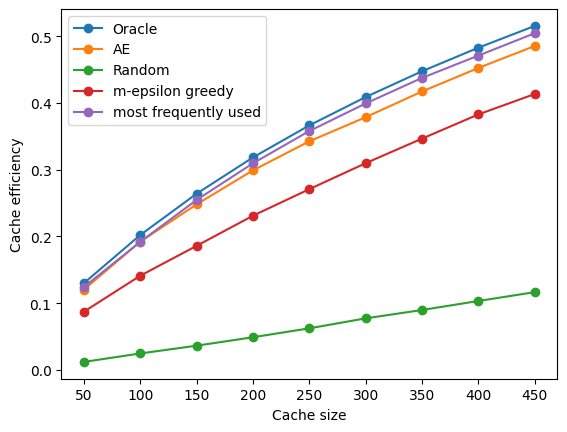

In [37]:
plt.figure(1)
x = range(50,500,50)
plt.plot(x,ce[5:50:5],'o-')
# plt.plot(x,ce,'o-')
# plt.plot(x,ts,'o-')
plt.xlabel('Cache size')
plt.ylabel('Cache efficiency')
# plt.legend(['Oracle','AE','Random','m-epsilon greedy','most frequently used','thompson'])
plt.legend(['Oracle','AE','Random','m-epsilon greedy','most frequently used'])

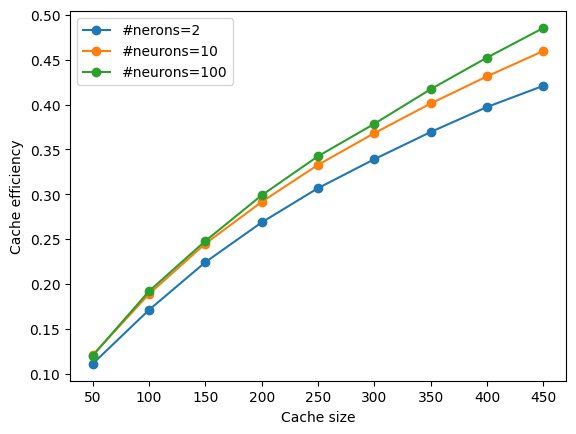

In [38]:
plt.figure(2)
plt.plot(x,ae_compare[5:50:5],'o-')
plt.xlabel('Cache size')
plt.ylabel('Cache efficiency')
plt.legend(['#nerons=2','#neurons=10','#neurons=100'])